# Sales Prediction with LightGBM

This notebook creates and trains a LightGBM model to predict the next week of sales for each identifier.

In [37]:
import warnings
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

# Suppress warnings
warnings.filterwarnings("ignore")

# Load and Prepare Data

In [38]:
# Load data
train_weekly = pd.read_parquet("processed_data/train.parquet")
test = pd.read_parquet("processed_data/test.parquet")

# Convert categories to numeric using LabelEncoder
# (feature dtypes must be int, float or bool)
le = LabelEncoder()
train_weekly["category_encoded"] = le.fit_transform(train_weekly["category"])
test["category_encoded"] = le.transform(test["category"])


# Calculate week number using the custom system (week 1 starts from May 1st, 2024)
def get_custom_week(date):
    week1_start = pd.Timestamp("2024-05-01")
    return (pd.Timestamp(date) - week1_start).days // 7 + 1


# Add week number to test data
test["week"] = test["period_start"].apply(get_custom_week)

print("Training data shape:", train_weekly.shape)
print("Test data shape:", test.shape)
print("\nFeatures available:", train_weekly.columns.tolist())

Training data shape: (130405, 12)
Test data shape: (2163, 9)

Features available: ['identifier', 'week', 'category', 'n_sold', 'contains_discount', 'contains_holiday', 'weeks_since_launch', 'weeks_since_last_discount', 'weeks_since_last_holiday', 'contains_discount_int', 'contains_holiday_int', 'category_encoded']


# Feature Engineering

In [39]:
# Add rolling statistics features
def add_rolling_features(df):
    df = df.sort_values(["identifier", "week"])

    rolling_windows = [1, 2, 3, 4, 5]
    for window in rolling_windows:
        df[f"sales_mean_{window}w"] = df.groupby("identifier")["n_sold"].transform(
            lambda x: x.shift(1).rolling(window, min_periods=1).mean()
        )
        df[f"sales_std_{window}w"] = df.groupby("identifier")["n_sold"].transform(
            lambda x: x.shift(1).rolling(window, min_periods=1).std()
        )
    return df


# Add category-level features
def add_category_features(df):
    cat_stats = (
        df.groupby("category_encoded").agg({"n_sold": ["mean", "std"]}).reset_index()
    )
    cat_stats.columns = ["category_encoded", "cat_mean_sales", "cat_std_sales"]
    df = df.merge(cat_stats, on="category_encoded", how="left")

    return df


# Add product-level features
def add_identifier_features(df):
    hist_stats = (
        df.groupby("identifier").agg({"n_sold": ["mean", "std", "max"]}).reset_index()
    )

    hist_stats.columns = [
        "identifier",
        "identifier_mean_sales",
        "identifier_std_sales",
        "identifier_max_sales",
    ]
    df = df.merge(hist_stats, on="identifier", how="left")

    return df


# Add additional features to the training data
training_df = train_weekly.copy()
training_df = add_rolling_features(training_df)
training_df = add_category_features(training_df)
training_df = add_identifier_features(training_df)

# Fill any missing values
training_df = training_df.fillna(0)

# Define features to use in the model
feature_columns = [
    "category_encoded",
    "week",
    "weeks_since_launch",
    "weeks_since_last_discount",
    "weeks_since_last_holiday",
] + [
    col
    for col in training_df.columns
    if "sales_" in col
    or "identifier_" in col
    or "cat_" in col
    or "'weeks_since_" in col
]

print("Features to be used in the model:", feature_columns)

Features to be used in the model: ['category_encoded', 'week', 'weeks_since_launch', 'weeks_since_last_discount', 'weeks_since_last_holiday', 'sales_mean_1w', 'sales_std_1w', 'sales_mean_2w', 'sales_std_2w', 'sales_mean_3w', 'sales_std_3w', 'sales_mean_4w', 'sales_std_4w', 'sales_mean_5w', 'sales_std_5w', 'cat_mean_sales', 'cat_std_sales', 'identifier_mean_sales', 'identifier_std_sales', 'identifier_max_sales']


# Train LightGBM Model

In [ ]:
# Detect numeric features
numeric_features = (
    training_df[feature_columns].select_dtypes(include=[np.number]).columns
)

# Prepare training data
X = training_df[feature_columns]
y = training_df["n_sold"]

# Split data into train and validation sets (last week for validation)
train_idx = training_df["week"] <= training_df["week"].max() - 1
X_train, X_val = X[train_idx], X[~train_idx]
y_train, y_val = y[train_idx], y[~train_idx]

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)


train_data = lgb.Dataset(X_train, label=y_train_log)
val_data = lgb.Dataset(X_val, label=y_val_log, reference=train_data)


# Optuna objective function
def objective(trial):

    def smape(A, F):
        return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

    params = {
        "objective": "regression",
        "metric": "mape",
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 10, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.3, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.3, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "verbose": -1,
        "feature_pre_filter": False,
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
    )

    preds = model.predict(X_val, num_iteration=model.best_iteration)
    mape = smape(np.expm1(y_val_log), np.expm1(preds))
    return mape


# Run optimization
study = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=100)

print("Best trial:")
print(study.best_trial.params)

# Train final model with best params
best_params = study.best_trial.params
best_params.update(
    {
        "objective": "regression",
        "metric": "mape",
        "boosting_type": "gbdt",
        "verbose": -1,
    }
)

model = lgb.train(
    best_params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
)
# Feature importance
importance = pd.DataFrame(
    {"feature": feature_columns, "importance": model.feature_importance()}
).sort_values("importance", ascending=False)

print("\nTop 10 most important features:")
print(importance.head(10))

[I 2025-08-25 16:15:58,906] A new study created in memory with name: no-name-893eb5a4-527a-4c4b-9060-99e49a2de939
[W 2025-08-25 16:15:59,488] Trial 0 failed with parameters: {'num_leaves': 118, 'learning_rate': 0.21887600007408953, 'feature_fraction': 0.8123957592679836, 'bagging_fraction': 0.7190609389379257, 'bagging_freq': 2, 'min_data_in_leaf': 19, 'lambda_l1': 0.5808361216819946, 'lambda_l2': 8.661761457749352} because of the following error: ValueError('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().').
Traceback (most recent call last):
  File "c:\Users\Dealan\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Dealan\AppData\Local\Temp\ipykernel_6196\3990319431.py", line 57, in objective
    mape = smape(np.expm1(y_val_log), np.expm1(preds))
  File "C:\Users\Dealan\AppData\Local\Temp\ipykernel_6196\3990319431.py", line 27, i

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Feature importance

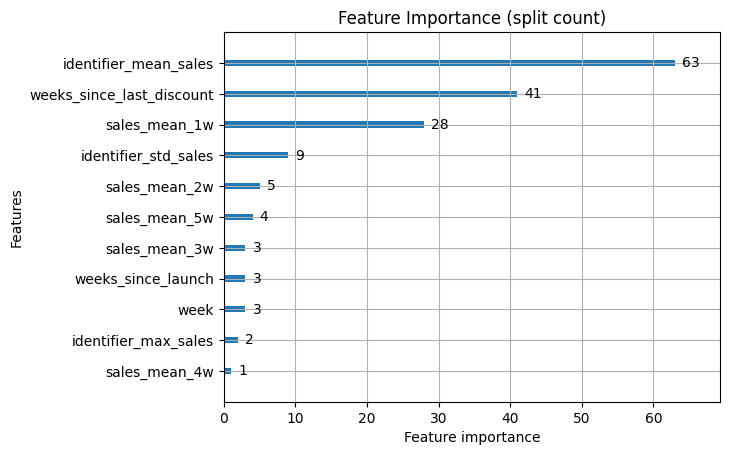

In [ ]:
lgb.plot_importance(model, max_num_features=40, importance_type="split")
plt.title("Feature Importance (split count)")
plt.show()

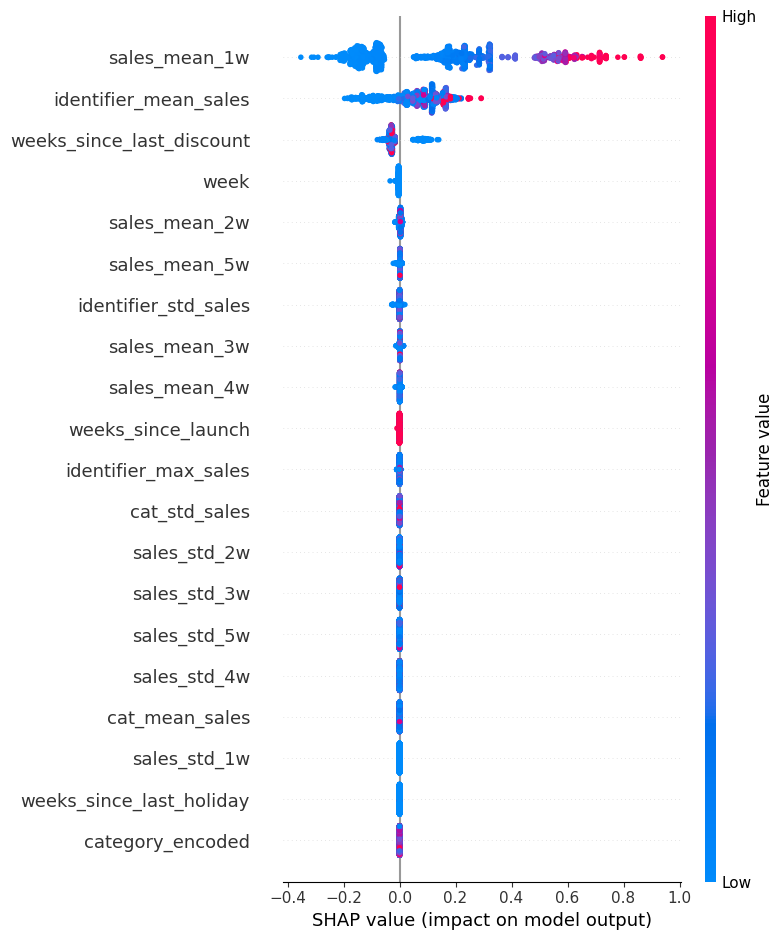

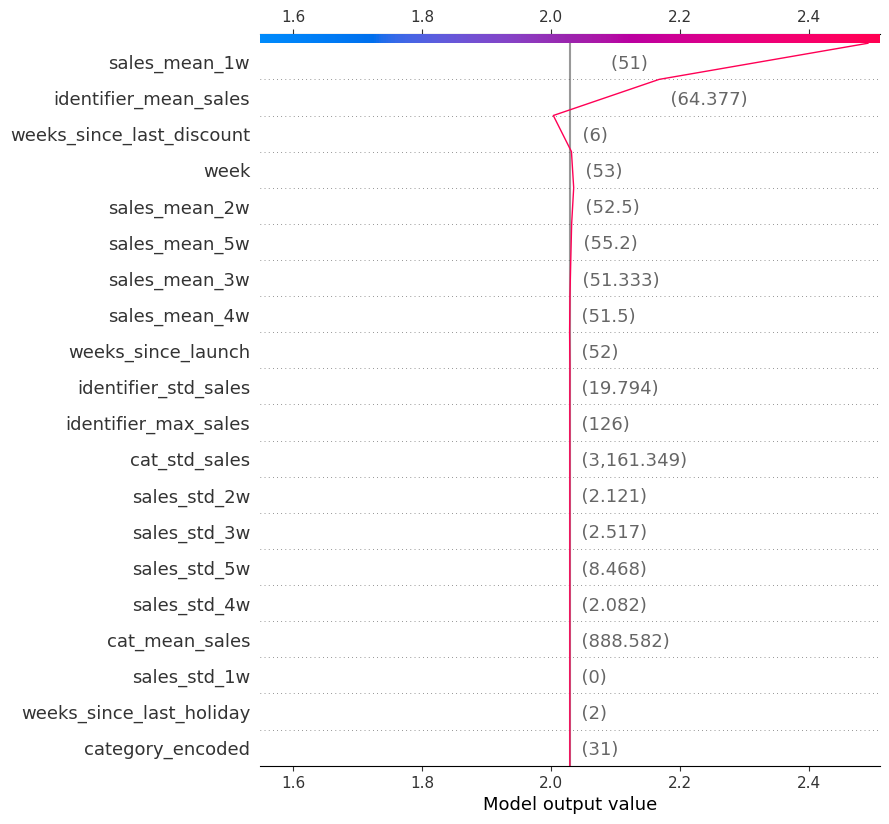

In [ ]:
explainer = shap.TreeExplainer(model)


shap_values = explainer.shap_values(X_val)


shap.summary_plot(shap_values, X_val, feature_names=feature_columns)


shap.decision_plot(
    explainer.expected_value,
    shap_values[0],
    X_val.iloc[0],
    feature_names=feature_columns,
)

# Generate Predictions for Week 53

Generate predictions for all identifiers in the test set (for the period 2025-05-01 to 2025-05-07)

In [ ]:
best_params

{'num_leaves': 55,
 'learning_rate': 0.07956226558903977,
 'feature_fraction': 0.9974962577435353,
 'bagging_fraction': 0.9456874358844807,
 'bagging_freq': 8,
 'min_data_in_leaf': 68,
 'lambda_l1': 4.767329294024212,
 'lambda_l2': 9.025241811005888,
 'objective': 'regression',
 'metric': 'mape',
 'boosting_type': 'gbdt',
 'verbose': -1}

# Train a model on the full training dataset, using the best hyperparameters found by Optuna

In [ ]:
# This time we will train the model on the entire training set
X_train = X
y_train = y
y_train_log = np.log1p(y_train)

train_data = lgb.Dataset(X_train, label=y_train_log)


# Best parameters obtained from previous optimization
final_model = lgb.train(
    best_params,
    train_data,
    num_boost_round=1000,
)

In [ ]:
# Prepare test data with the same features as training data
test_features = test.copy()

In [ ]:
# Add rolling statistics from the training data
latest_stats = (
    training_df.groupby("identifier")
    .agg(
        {
            "n_sold": ["mean", "std", "max"],
            "sales_mean_1w": "last",
            "sales_mean_2w": "last",
            "sales_mean_3w": "last",
            "sales_mean_4w": "last",
            "sales_mean_5w": "last",
            "sales_std_1w": "last",
            "sales_std_2w": "last",
            "sales_std_3w": "last",
            "sales_std_4w": "last",
            "sales_std_5w": "last",
        }
    )
    .reset_index()
)

# Rename columns to match training features
latest_stats.columns = (
    ["identifier"]
    + ["identifier_mean_sales", "identifier_std_sales", "identifier_max_sales"]
    + [
        "sales_mean_1w",
        "sales_mean_2w",
        "sales_mean_3w",
        "sales_mean_4w",
        "sales_mean_5w",
        "sales_std_1w",
        "sales_std_2w",
        "sales_std_3w",
        "sales_std_4w",
        "sales_std_5w",
    ]
)

# Merge statistics with test data
test_features = test_features.merge(latest_stats, on="identifier", how="left")

# Add category-level features from training data
cat_stats = (
    training_df.groupby("category_encoded")
    .agg({"n_sold": ["mean", "std"]})
    .reset_index()
)
cat_stats.columns = ["category_encoded", "cat_mean_sales", "cat_std_sales"]
test_features = test_features.merge(cat_stats, on="category_encoded", how="left")


# Ensure correct column order and types
test_features["weeks_since_launch"] = test_features["weeks_since_launch"].astype(int)

# Fill missing values
test_features = test_features.fillna(0)

test_features.head()

,identifier,period_start,period_end,category,week,weeks_since_launch,weeks_since_last_holiday,weeks_since_last_discount,category_encoded,identifier_mean_sales,...,sales_mean_3w,sales_mean_4w,sales_mean_5w,sales_std_1w,sales_std_2w,sales_std_3w,sales_std_4w,sales_std_5w,cat_mean_sales,cat_std_sales
0,00119a49e3,2025-05-01,2025-05-07,71e3583839,53,30,0,2,15,7.266667,...,7.333333,6.50,6.2,0.0,1.414214,3.055050,3.000000,2.683282,18.793506,44.654578
1,001630a8c1,2025-05-01,2025-05-07,d2ed91b77c,53,53,0,7,31,64.377358,...,51.333333,51.50,55.2,0.0,2.121320,2.516611,2.081666,8.467585,888.582353,3161.349326
2,009419bbaf,2025-05-01,2025-05-07,43fb29e4a1,53,52,0,3,8,1.807692,...,2.666667,2.75,2.2,0.0,2.121320,1.527525,1.258306,1.643168,11.561585,26.658505
3,00a179934c,2025-05-01,2025-05-07,98e5f29fc8,53,53,0,4,27,19.301887,...,26.000000,25.50,25.6,0.0,20.506097,19.467922,15.926916,13.794927,19.185989,43.137234
4,0106a86d3b,2025-05-01,2025-05-07,71e3583839,53,37,0,8,15,15.054054,...,12.666667,12.00,12.6,0.0,2.828427,3.511885,3.162278,3.049590,18.793506,44.654578


# Create and Save Final Predictions

In [ ]:
# Generate predictions
X_test = test_features[feature_columns]
predictions = final_model.predict(X_test)
predictions = np.expm1(predictions)  # Convert back to original scale
# Create results dataframe
results = pd.DataFrame(
    {
        "identifier": test_features["identifier"],
        "period_start": test_features["period_start"],
        "period_end": test_features["period_end"],
        "predicted_sales": (np.maximum(0, predictions)).astype(
            int
        ),  # Ensure non-negative integer predictions
    }
)

print("Sample predictions:")
print(results.head(50))

# Print summary statistics
print("\nPrediction Summary:")
print(f"Total predictions generated: {len(results)}")
print(f"Average predicted sales: {results['predicted_sales'].mean():.2f}")
print(f"Median predicted sales: {results['predicted_sales'].median()}")
print(f"Max predicted sales: {results['predicted_sales'].max()}")
print(f"Min predicted sales: {results['predicted_sales'].min()}")

Sample predictions:
    identifier period_start  period_end  predicted_sales
0   00119a49e3   2025-05-01  2025-05-07                0
1   001630a8c1   2025-05-01  2025-05-07                5
2   009419bbaf   2025-05-01  2025-05-07                0
3   00a179934c   2025-05-01  2025-05-07                1
4   0106a86d3b   2025-05-01  2025-05-07                1
5   01115386c1   2025-05-01  2025-05-07                0
6   0112d42550   2025-05-01  2025-05-07                1
7   01223f695c   2025-05-01  2025-05-07                1
8   012dfc7ad0   2025-05-01  2025-05-07                3
9   0138bb2c68   2025-05-01  2025-05-07                1
10  0158251d1c   2025-05-01  2025-05-07                2
11  01c472a4c2   2025-05-01  2025-05-07                3
12  01d31a946a   2025-05-01  2025-05-07                0
13  01d62a49cd   2025-05-01  2025-05-07                0
14  01ecf9c0f5   2025-05-01  2025-05-07                3
15  021f3efc5c   2025-05-01  2025-05-07                0
16  0253522

In [ ]:
# Converet predictions to requested format
results = results[["identifier", "predicted_sales"]].rename(
    columns={"predicted_sales": "prediction"}
)

# Save predictions
output_dir = Path("predictions")
output_dir.mkdir(exist_ok=True)
output_path = output_dir / "lightgbm_predictions.parquet"
results.to_parquet(output_path, index=False)

print(f"\nPredictions saved to {output_path}")


Predictions saved to predictions\lightgbm_predictions.parquet
